## Deep Learning
Within this notebook, an effort is made to combine all 3 types of uncertainty into the neural network.

In [1]:
#importing necessary packages
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Input
import pandas as pd
import numpy as np
import random
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from keras.backend import clear_session
from keras.layers import Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.backend import clear_session
from keras.layers import Dense, Activation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

First we create the worst-case and best-case scenarios based on the non-normalized test data. 

In [29]:
#read dataframe from the Data Preparation Notebook 
import pandas as pd
df_complete3 = pd.read_pickle('df_complete3_v3.pickle')

In [30]:
#change types of the whole dataframe so that we do not run out of memory during the training process 
df_complete3 = df_complete3.astype(np.uint8)

In [31]:
df_complete3.shape

(100040, 45)

In [32]:
#split off target column
target_column = df_complete3['number of conflicts']
df_complete3.drop(columns = ['number of conflicts'], inplace = True)

In [33]:
#perform train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_complete3, target_column, test_size = 0.08, random_state = 0)


In [7]:
#normalization is only done after defining the best and worst case scenarios! 
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [9]:
#defining the numeric predictors for the multiplication
numeric_predictors = ['gender development index (GDI)', 'human development index (HDI)',
       'health index', 'income index', 'educational index',
       'expected years of schooling', 'mean years of scholing',
       'life expectancy', "GNI per capita (000'000)",
       "population (000'000)",
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Consumer price index (2010 = 100)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'GDP (constant 2015 US$)', 'GDP per capita (constant 2015 US$)',
       'Oil rents (% of GDP)',
       'Refugee population by country or territory of asylum',
       'Rural population (% of total population)',
       'Unemployment, female (% of female labor force) (modeled ILO estimate)',
       'Unemployment, male (% of male labor force) (modeled ILO estimate)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)']

Adding some randomness to the best, normal and worst case. It is very unlikely that all variables are worse at the same time. That's why, we use a random component around the datapoints. 


In [10]:
#defining normal distributions with a specific mean and standard deviation
mu_normal, sigma_normal= 0, 0.01 # mean and standard deviation
dis_normal = np.random.normal(mu_normal, sigma_normal, 1000)

mu_lower, sigma_lower= -0.05, 0.01 # mean and standard deviation
dis_lower = np.random.normal(mu_lower, sigma_lower, 1000)

mu_upper, sigma_upper= 0.05, 0.01 # mean and standard deviation
dis_upper = np.random.normal(mu_upper, sigma_upper, 1000)


In [11]:
#create probability around upper - by rows and columns 
test_df_upper = X_test.copy()
for index, row in test_df_upper.iterrows():
    for column in numeric_predictors: 
        test_df_upper.at[index, column] = row[column]*(1+random.choice(dis_upper))

In [12]:
#create probability around lower - by rows and columns
test_df_lower = X_test.copy()
for index, row in test_df_lower.iterrows():
    for column in numeric_predictors: 
        test_df_lower.at[index, column] = row[column]*(1+random.choice(dis_lower))

In [13]:
#create probability around lower - by rows and columsn 
test_df_normal = X_test.copy()
for index, row in test_df_normal.iterrows():
    for column in numeric_predictors: 
        test_df_normal.at[index, column] = row[column]*(1+random.choice(dis_normal))

In [34]:
#now we standardize the original datasets 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [15]:
#we also standardize the datasets with uncertainty
test_df_normal = sc.transform(test_df_normal)
test_df_lower = sc.transform(test_df_lower)
test_df_upper = sc.transform(test_df_upper)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [16]:
#now we need to remove the seed for uncertainty and set 

In [17]:
#now we do the resampling
#change the dropout setting through the dropout class class

#setting the seed for reproducibility
cross_validation = KFold(n_splits = 5, shuffle = True)#, random_state = 10)

class MontheCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = True)

In [18]:
clear_session()
model = Sequential()
del model
model = Sequential()

model.add(Dense(40, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(4)))
model.add(Dropout(0.0))
model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(30, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))

# Compile model
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mean_squared_error'])

#model.fit(X_train, y_train, epochs = 50, batch_size = 2000)

In [19]:
#Monte Carlo 

#apply dropout also at test time in order to get many predictions!
#with this, we can analyze the distribution or get the average
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [20]:
#predicting the values mutliple times for resampling -this was done twice and the values have been saved 
#to csv files which are imported in the following
predictions_normal = pd.DataFrame()
predictions_upper = pd.DataFrame()
predictions_lower = pd.DataFrame()

for i in range(0,100):
    model_name = "model" + str(i)
    print(model_name)
  #  model = KerasRegressor(model=wider_larger_model, verbose=0, epochs = 50, batch_size = 2000, optimizer = "Adam",
                #      optimizer__learning_rate = 0.1, loss = 'mean_squared_error')

    # define the grid search parameters
  #  weight_constraint = [4]
    
  #  dropout_rate = [0.0]
    # Make a dictionary of the grid search parameters
  #  param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint = weight_constraint )

  #  grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=1, cv= cross_validation, scoring = "neg_mean_squared_error")
    model.fit(X_train, y_train, epochs = 50, batch_size = 2000, verbose = 0)
    
   # y_pred_train = grid.predict(X_train)
#    y_pred_test = grid.predict(test_df_normal)
    y_pred_normal = predict_point(test_df_normal, model, 1000)
    y_pred_lower = predict_point(test_df_lower, model, 1000)
    y_pred_upper = predict_point(test_df_upper, model, 1000)
    
   # predictions_train[model_name] = y_pred_train
    predictions_normal[model_name] = y_pred_normal
    predictions_lower[model_name] = y_pred_lower
    predictions_upper[model_name] = y_pred_upper

model0
model1
model2
model3
model4


KeyboardInterrupt: 

In [ ]:
#export files for direct processing
predictions_normal.to_csv("combined_uncertainty_normal.csv")
predictions_lower.to_csv("combined_uncertainty_lower.csv")
predictions_upper.to_csv("combined_uncertainty_upper.csv")

In [2]:
#import files for direct processing
predictions_normal = pd.read_csv("combined_uncertainty_normal.csv", index_col = 0)
predictions_lower = pd.read_csv("combined_uncertainty_lower.csv", index_col =0)
predictions_upper = pd.read_csv("combined_uncertainty_upper.csv", index_col = 0)

In [3]:
predictions_normal

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model90,model91,model92,model93,model94,model95,model96,model97,model98,model99
0,0.648833,0.676072,0.683033,0.650262,0.667067,0.826739,0.577767,0.570563,0.566533,0.614683,...,0.672795,0.702335,0.659154,0.692597,0.717668,0.680234,0.715840,0.711804,0.648313,0.602787
1,0.638874,0.685910,0.706039,0.645537,0.634322,0.731515,0.590934,0.550774,0.533826,0.567644,...,0.672795,0.702335,0.659154,0.692774,0.722183,0.680234,0.717942,0.710813,0.648225,0.597932
2,0.755539,0.674804,0.683488,0.650120,0.725654,1.023071,0.561652,0.574042,0.557685,0.557540,...,0.672795,0.702335,0.659137,0.691784,0.683087,0.682568,0.715771,0.745820,0.648163,0.594413
3,0.884747,0.714993,0.853146,0.725614,1.224869,1.436800,0.735974,0.799168,0.602922,0.565853,...,0.673594,0.706870,0.659136,0.698675,0.867302,0.718485,0.735573,0.714032,0.677707,0.654954
4,38.169945,63.681060,63.238014,78.587875,67.311990,56.670017,70.005300,60.980556,87.736350,70.389840,...,76.762375,59.058960,55.074913,78.103630,46.339806,93.015980,70.419266,69.555080,43.294476,59.323070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,0.662061,0.671581,0.739682,0.659766,0.878512,0.702663,0.613039,0.563487,0.602554,0.556352,...,0.673914,0.702335,0.696524,0.692072,0.683073,0.680234,0.716108,0.711643,0.648181,0.598223
8000,1.226657,2.385251,2.040340,1.505766,1.323591,1.754854,1.217513,1.528386,0.729470,0.687522,...,0.682406,0.799871,0.660887,0.696262,0.808705,0.799175,0.937630,1.080121,0.674538,0.793543
8001,0.722305,0.652494,0.768077,0.771375,0.796014,0.736975,0.606431,0.568619,0.591120,0.557449,...,0.708801,0.702335,0.659147,0.695197,0.683061,0.680234,0.718406,0.711044,0.648170,0.613073
8002,0.866121,0.668361,0.670285,0.702004,0.738097,1.028507,0.609644,0.539400,0.563214,0.558575,...,0.672795,0.702335,0.659145,0.691784,0.687023,0.681472,0.715782,0.711293,0.648599,0.593540


In [4]:
#predictions_normal
#now we do bootstrapping for each of the scenarios 
resample_mean_mean = [] #mean of the resample
lower_ci = [] #lower confidence interval of resampled mean
upper_ci =  [] #upper confidence interval of resampled mean
alpha = 0.95 #confidence level
df_normal = pd.DataFrame(columns = range(1, 100) )

for index, row in predictions_normal.iterrows():
    resample_mean = []
    
    for i in range(1, 100):
        row_temp = predictions_normal.loc[index, :].values.tolist()
        y = random.choices(row_temp, k = 100)
        avg = np.mean(y)
        resample_mean.append(avg)
    
    #calculate the confidence interval for ther resampled means 
    resample_mean.sort()
    df_normal.loc[len(df_normal)] = resample_mean
    lower = np.percentile(resample_mean, 1)
    upper = np.percentile(resample_mean,99)
    
  #  x = np.percentile(resample_mean, [1, 50, 97.5])
    lower_ci.append(lower)
    upper_ci.append(upper)
    
    #calculate the mean of the resampled means
    resample_mean_mean.append(np.mean(resample_mean))

In [5]:
df_normal

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
0,0.649555,0.650151,0.651811,0.654111,0.654675,0.655295,0.656298,0.658123,0.658177,0.658414,...,0.683090,0.684027,0.684286,0.684942,0.685470,0.687491,0.688925,0.689040,0.689375,0.692749
1,0.641179,0.643435,0.647155,0.648547,0.649624,0.650471,0.650864,0.651323,0.651632,0.651662,...,0.676215,0.676596,0.676655,0.676957,0.679312,0.679628,0.679750,0.681976,0.683587,0.684827
2,0.631092,0.641106,0.642419,0.643249,0.644910,0.646905,0.647224,0.647333,0.647795,0.648865,...,0.675041,0.675854,0.675954,0.677491,0.679702,0.680233,0.680407,0.681719,0.685010,0.691382
3,0.682623,0.684588,0.690349,0.691624,0.694427,0.697887,0.698933,0.701676,0.701715,0.703343,...,0.760655,0.762148,0.763682,0.766266,0.768256,0.771232,0.773540,0.774659,0.787419,0.787463
4,62.986264,63.215681,63.637410,63.702473,63.862040,64.001205,64.047354,64.085914,64.140119,64.170566,...,67.505553,67.621695,67.648554,67.649081,67.677326,67.688439,67.786182,67.959142,68.487420,68.603078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,0.641840,0.650341,0.650556,0.651774,0.655927,0.658227,0.658580,0.659185,0.659681,0.660646,...,0.682997,0.683756,0.683977,0.684783,0.685119,0.688407,0.690571,0.690823,0.691283,0.693396
8000,0.797567,0.797574,0.800686,0.805985,0.806737,0.811510,0.812189,0.815644,0.820154,0.820800,...,0.890177,0.895511,0.900320,0.900930,0.907025,0.909978,0.910867,0.911781,0.935344,0.946348
8001,0.651946,0.658422,0.661867,0.668609,0.668699,0.669082,0.669125,0.671380,0.671904,0.673115,...,0.731555,0.733940,0.736405,0.737308,0.738056,0.740375,0.742498,0.767515,0.775853,0.789613
8002,0.644272,0.646205,0.647878,0.648039,0.650298,0.650709,0.651620,0.651735,0.652758,0.652793,...,0.679154,0.681369,0.684888,0.685018,0.685294,0.685747,0.686276,0.686867,0.688608,0.696528


In [12]:
#all the different calculated measures are written into a new dataframe
new_df_normal = pd.DataFrame()

new_df_normal["lower_ci"] = lower_ci
new_df_normal["upper_ci"] = upper_ci
new_df_normal["resample_mean"] = resample_mean_mean
new_df_normal["original_mean"] = predictions_normal.apply(lambda x: x.mean(), axis = 1)
new_df_normal["difference"] = new_df_normal["upper_ci"] - new_df_normal["lower_ci"] 
#new_df["original_pred"] = y_pred_test1
new_df_normal["actual_value"] = y_test.to_numpy()
new_df_normal

,lower_ci,upper_ci,resample_mean,original_mean,difference,actual_value
0,0.650139,0.689443,0.671369,0.670961,0.039303,0
1,0.643390,0.683612,0.662629,0.663786,0.040222,0
2,0.640905,0.685137,0.661913,0.662532,0.044232,0
3,0.684548,0.787420,0.730912,0.733430,0.102871,0
4,63.211093,68.489733,65.731746,65.659712,5.278641,50
...,...,...,...,...,...,...
7999,0.650171,0.691326,0.671677,0.670956,0.041154,0
8000,0.797574,0.935564,0.853397,0.849149,0.137990,4
8001,0.658292,0.776128,0.698705,0.697076,0.117836,0
8002,0.646166,0.688766,0.665528,0.665603,0.042600,0


In [13]:
#predictions_normal
#now we do bootstrapping for each of the scenarios 
resample_mean_mean = [] #mean of the resample
lower_ci = [] #lower confidence interval of resampled mean
upper_ci =  [] #upper confidence interval of resampled mean
alpha = 0.95 #confidence level
df_lower = pd.DataFrame(columns = range(1, 200) )

for index, row in predictions_lower.iterrows():
    resample_mean = []
    
    for i in range(1, 200):
        row_temp = predictions_lower.loc[index, :].values.tolist()
        y = random.choices(row_temp, k = 100)
        avg = np.mean(y)
        resample_mean.append(avg)
    
    #calculate the confidence interval for ther resampled means 
    resample_mean.sort()
    df_lower.loc[len(df_lower)] = resample_mean
    lower = np.percentile(resample_mean, 1)
    upper = np.percentile(resample_mean,99)
    
  #  x = np.percentile(resample_mean, [1, 50, 97.5])
    lower_ci.append(lower)
    upper_ci.append(upper)
    
    #calculate the mean of the resampled means
    resample_mean_mean.append(np.mean(resample_mean))

In [14]:
#all the different calculated measures are written into a new dataframe
new_df_lower = pd.DataFrame()

new_df_lower["lower_ci"] = lower_ci
new_df_lower["upper_ci"] = upper_ci
new_df_lower["resample_mean"] = resample_mean_mean
new_df_lower["original_mean"] = predictions_lower.apply(lambda x: x.mean(), axis = 1)
new_df_lower["difference"] = new_df_lower["upper_ci"] - new_df_lower["lower_ci"] 
#new_df["original_pred"] = y_pred_test1
new_df_lower["actual_value"] = y_test.to_numpy()
new_df_lower

,lower_ci,upper_ci,resample_mean,original_mean,difference,actual_value
0,0.653398,0.697711,0.671714,0.671626,0.044313,0
1,0.646019,0.683660,0.664667,0.664701,0.037641,0
2,0.642894,0.687119,0.663622,0.663386,0.044224,0
3,0.666034,0.724245,0.690171,0.689832,0.058211,0
4,50.046933,55.245321,52.494329,52.438199,5.198387,50
...,...,...,...,...,...,...
7999,0.650810,0.695377,0.672233,0.671734,0.044567,0
8000,0.737508,0.832934,0.782013,0.783183,0.095426,4
8001,0.661881,0.714884,0.685319,0.686208,0.053003,0
8002,0.644561,0.687400,0.665285,0.665639,0.042839,0


In [15]:
#predictions_normal
#now we do bootstrapping for each of the scenarios 
resample_mean_mean = [] #mean of the resample
lower_ci = [] #lower confidence interval of resampled mean
upper_ci =  [] #upper confidence interval of resampled mean
alpha = 0.95 #confidence level
df_upper = pd.DataFrame(columns = range(1, 200) )

for index, row in predictions_upper.iterrows():
    resample_mean = []
    
    for i in range(1, 200):
        row_temp = predictions_upper.loc[index, :].values.tolist()
        y = random.choices(row_temp, k = 100)
        avg = np.mean(y)
        resample_mean.append(avg)
    
    #calculate the confidence interval for ther resampled means 
    resample_mean.sort()
    df_upper.loc[len(df_upper)] = resample_mean
    lower = np.percentile(resample_mean, 1)
    upper = np.percentile(resample_mean,99)
    
  #  x = np.percentile(resample_mean, [1, 50, 97.5])
    lower_ci.append(lower)
    upper_ci.append(upper)
    
    #calculate the mean of the resampled means
    resample_mean_mean.append(np.mean(resample_mean))

In [16]:
#all the different calculated measures are written into a new dataframe
new_df_upper = pd.DataFrame()

new_df_upper["lower_ci"] = lower_ci
new_df_upper["upper_ci"] = upper_ci
new_df_upper["resample_mean"] = resample_mean_mean
new_df_upper["original_mean"] = predictions_upper.apply(lambda x: x.mean(), axis = 1)
new_df_upper["difference"] = new_df_upper["upper_ci"] - new_df_upper["lower_ci"] 
#new_df["original_pred"] = y_pred_test1
new_df_upper["actual_value"] = y_test.to_numpy()
new_df_upper

,lower_ci,upper_ci,resample_mean,original_mean,difference,actual_value
0,0.650599,0.695223,0.675099,0.675215,0.044625,0
1,0.652025,0.691590,0.670801,0.671158,0.039566,0
2,0.646689,0.690991,0.665133,0.664985,0.044302,0
3,0.733628,0.899334,0.813314,0.813471,0.165706,0
4,59.789049,65.624938,62.423457,62.533812,5.835889,50
...,...,...,...,...,...,...
7999,0.653473,0.695622,0.674231,0.674050,0.042149,0
8000,0.900854,1.455388,1.107347,1.121552,0.554534,4
8001,0.666406,0.793483,0.706783,0.706193,0.127077,0
8002,0.641679,0.688668,0.667420,0.667466,0.046989,0


In [35]:
## now i need to calculate the original stuff 

#setting the seed for reproducibility
cross_validation = KFold(n_splits = 5, shuffle = True, random_state = 10)

seed = 14
tf.random.set_seed(14)

#now we do the resampling
#change the dropout setting through the class
class MontheCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = False)

In [36]:
clear_session()
model = Sequential()
del model
model = Sequential()

model.add(Dense(40, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(4)))
model.add(Dropout(0.0))
model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(30, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))

# Compile model
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mean_squared_error'])

model.fit(X_train, y_train, epochs = 50, batch_size = 2000)

#create original predictions for all 3 datasets

#predictions are created for both the train and the test set
y_pred_normal_original = model.predict(test_df_normal)
y_pred_lower_original = model.predict(test_df_lower)
y_pred_upper_original = model.predict(test_df_upper)

Epoch 1/50
47/47 [==============================] - 2s 13ms/step - loss: 320.9381 - mean_squared_error: 320.9381
Epoch 2/50
47/47 [==============================] - 1s 11ms/step - loss: 291.7386 - mean_squared_error: 291.7386
Epoch 3/50
47/47 [==============================] - 1s 11ms/step - loss: 260.8683 - mean_squared_error: 260.8683
Epoch 4/50
47/47 [==============================] - 1s 12ms/step - loss: 231.1536 - mean_squared_error: 231.1536
Epoch 5/50
47/47 [==============================] - 1s 11ms/step - loss: 197.4563 - mean_squared_error: 197.4563
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 197.2903 - mean_squared_error: 197.2903
Epoch 7/50
47/47 [==============================] - 1s 12ms/step - loss: 180.7682 - mean_squared_error: 180.7682
Epoch 8/50
47/47 [==============================] - 1s 12ms/step - loss: 169.9673 - mean_squared_error: 169.9673
Epoch 9/50
47/47 [==============================] - 1s 12ms/step - loss: 229.1109 - mean_squared

NameError: name 'test_df_normal' is not defined

In [37]:
y_pred = model.predict(X_test)

In [20]:
new_df_upper["original_pred"] = y_pred_upper_original
new_df_lower["original_pred"] = y_pred_lower_original
new_df_normal["original_pred"] = y_pred_normal_original

NameError: name 'y_pred_upper_original' is not defined

In [21]:
#metrics on resampled mean for the best guess scenario
y_pred_resampled_mean = new_df_normal[["resample_mean"]].to_numpy() 
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  2.920642906574164
Resampled Mean test MSE =  93.3904316843637


Resampled Mean test MAE =  2.920642906574164
Resampled Mean test MSE =  93.3904316843637

In [23]:
#metrics on resampled mean for the best guess scenario rounded down
y_pred_resampled_mean_floor = new_df_normal["resample_mean"].apply(np.floor)
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean_floor)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean_floor)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  2.4381559220389803
Resampled Mean test MSE =  93.73200899550226


Resampled Mean test MAE =  2.4381559220389803
Resampled Mean test MSE =  93.73200899550226

In [96]:
#metrics on the original best guess scenario 
MSE_test = mean_squared_error(y_test, y_pred_normal_original)
MAE_test = mean_absolute_error(y_test , y_pred_normal_original)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.3339245
Resampled Mean test MSE =  106.95448


Resampled Mean test MAE =  3.3339245
Resampled Mean test MSE =  106.95448

In [26]:
#metrics on resampled mean for the best case scenario 
y_pred_resampled_mean = new_df_upper[["resample_mean"]].to_numpy() 
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.115549185758231
Resampled Mean test MSE =  98.42121572435985


Resampled Mean test MAE =  3.115549185758231
Resampled Mean test MSE =  98.42121572435985

In [41]:
#metrics on resampled mean for the worst case scenario rounded down
y_pred_resampled_mean_floor = new_df_upper["resample_mean"].apply(np.floor)
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean_floor)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean_floor)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  2.6424287856071964
Resampled Mean test MSE =  98.61669165417291


Resampled Mean test MAE =  2.6424287856071964
Resampled Mean test MSE =  98.61669165417291

In [98]:
#metrics on the original best case scenario 
MSE_test = mean_squared_error(y_test, y_pred_upper_original)
MAE_test = mean_absolute_error(y_test , y_pred_upper_original)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.8164008
Resampled Mean test MSE =  132.16667


Resampled Mean test MAE =  3.8164008
Resampled Mean test MSE =  132.16667

In [99]:
#metrics on resampled mean for the worst case scenario 
y_pred_resampled_mean = new_df_lower[["resample_mean"]].to_numpy() 
MSE_test = mean_squared_error(y_test, 
                              y_pred_resampled_mean)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.030326409429813
Resampled Mean test MSE =  101.66640662867059


Resampled Mean test MAE =  3.030326409429813
Resampled Mean test MSE =  101.66640662867059

In [27]:
#metrics on resampled mean for the worst case scenario rounded down
y_pred_resampled_mean_floor = new_df_lower["resample_mean"].apply(np.floor)
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean_floor)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean_floor)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  2.5533483258370815
Resampled Mean test MSE =  102.17978510744628


Resampled Mean test MAE =  2.5533483258370815
Resampled Mean test MSE =  102.17978510744628

In [100]:
#metrics on the original worst case scenario
MSE_test = mean_squared_error(y_test, y_pred_lower_original)
MAE_test = mean_absolute_error(y_test , y_pred_lower_original)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.6419382
Resampled Mean test MSE =  126.97667


Resampled Mean test MAE =  3.6419382
Resampled Mean test MSE =  126.97667

In [38]:
#metrics on the original test set 
MSE_test = mean_squared_error(y_test, y_pred)
MAE_test = mean_absolute_error(y_test , y_pred)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.3535175
Resampled Mean test MSE =  110.94073


Resampled Mean test MAE =  3.3535175
Resampled Mean test MSE =  110.94073

In [40]:
#metrics on original test set rounded down
y_pred_floor = np.floor(y_pred)
MSE_test = mean_squared_error(y_test, y_pred_floor)
MAE_test = mean_absolute_error(y_test , y_pred_floor)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  2.858446
Resampled Mean test MSE =  110.83471


Creating some visualizations

In [103]:
new_df_normal.to_csv("new_df_normal.csv")
new_df_upper.to_csv("new_df_upper.csv")
new_df_lower.to_csv("new_df_lower.csv")

In [104]:
df_upper.to_csv("df_upper.csv")
df_normal.to_csv("df_normal.csv")
df_lower.to_csv("df_lower.csv")

In [110]:
new_df_upper

,lower_ci,upper_ci,resample_mean,original_mean,difference,actual_value,original_pred
0,0.652470,0.695753,0.675156,0.675215,0.043282,0,0.719319
1,0.648786,0.695495,0.671050,0.671158,0.046709,0,0.719319
2,0.645825,0.689836,0.665939,0.664985,0.044012,0,0.719319
3,0.737802,0.924014,0.814368,0.813471,0.186212,0,0.719319
4,59.892921,65.779032,62.546522,62.533812,5.886111,50,49.421290
...,...,...,...,...,...,...,...
7999,0.654603,0.694749,0.674380,0.674050,0.040146,0,0.719319
8000,0.894026,1.545059,1.122360,1.121552,0.651033,4,3.233958
8001,0.661044,0.803412,0.711318,0.706193,0.142368,0,0.719319
8002,0.645494,0.692803,0.669101,0.667466,0.047309,0,0.719319


In [105]:
import pandas as pd

df_upper = pd.read_csv("df_upper.csv", index_col = 0)
df_normal = pd.read_csv("df_normal.csv", index_col = 0)
df_lower = pd.read_csv("df_lower.csv", index_col = 0)

new_df_upper = pd.read_csv("new_df_upper.csv", index_col = 0)
new_df_normal = pd.read_csv("new_df_normal.csv", index_col = 0)
new_df_lower = pd.read_csv("new_df_lower.csv", index_col = 0)

In [111]:
new_df_upper["original_pred_noUn"] = y_pred
new_df_lower["original_pred_noUn"] = y_pred
new_df_normal["original_pred_noUn"] = y_pred

In [117]:
new_df_normal.to_excel("new_df_normal.xlsx")

In [120]:
df_upper_row = df_upper[47:48].to_numpy()
df_upper_row =df_upper_row[0]

df_normal_row = df_normal[47:48].to_numpy()
df_normal_row =df_normal_row[0]

df_lower_row = df_lower[47:48].to_numpy()
df_lower_row =df_lower_row[0]

new_df_upper_row = new_df_upper[47:48].to_numpy()
new_df_upper_row =new_df_upper_row[0]

new_df_normal_row = new_df_normal[47:48].to_numpy()
new_df_normal_row = new_df_normal_row[0]

new_df_lower_row = new_df_lower[47:48].to_numpy()
new_df_lower_row =new_df_lower_row[0]

In [121]:
new_df_normal_row[5] #actual value
new_df_normal_row[6] #original prediction
new_df_normal_row[0] #lower CI
new_df_normal_row[1] #upper CI

1.585112760274

C:\Users\Shadow\AppData\Local\Temp\ipykernel_23348\540102958.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_upper_row, shade=True, color="dodgerblue", label = "best-case scenario")
C:\Users\Shadow\AppData\Local\Temp\ipykernel_23348\540102958.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_lower_row, shade=True, color="lightskyblue", label = "worst-case scenario")
C:\Users\Shadow\AppData\Local\Temp\ipykernel_23348\540102958.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_normal_row, shade=True, color="lightgreen", label ="best guess")


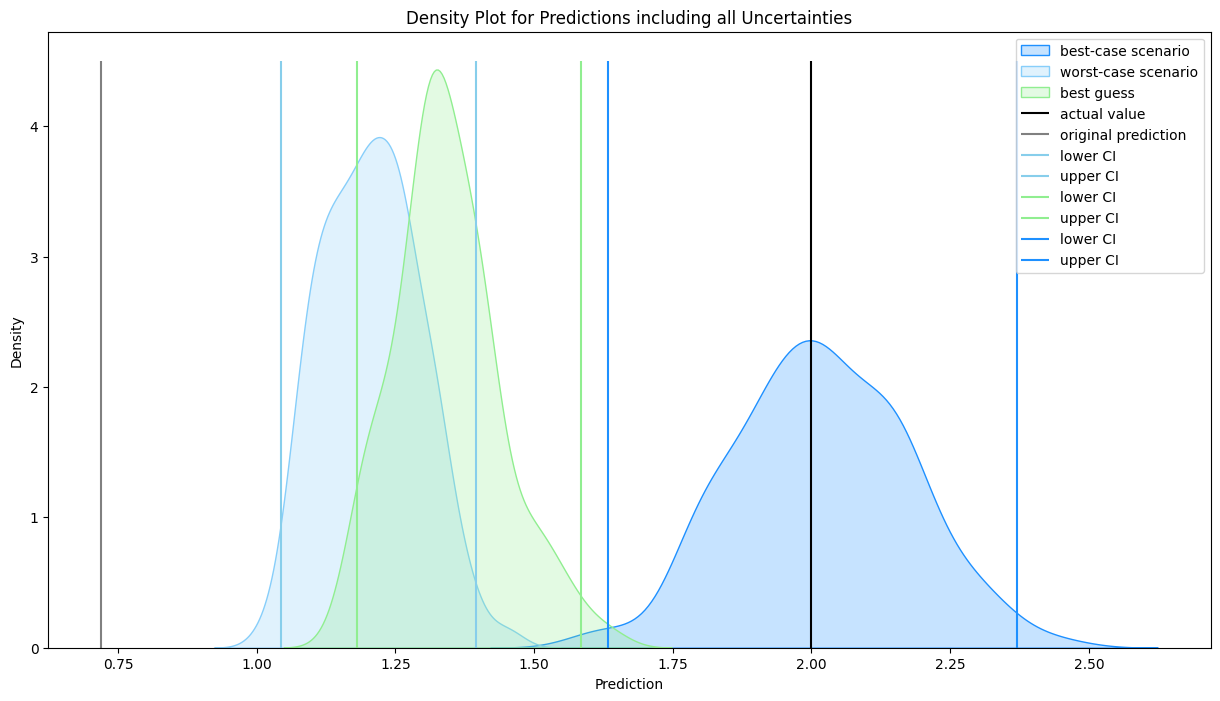

In [132]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
# plotting both distibutions on the same figure
sns.kdeplot(df_upper_row, shade=True, color="dodgerblue", label = "best-case scenario")
sns.kdeplot(df_lower_row, shade=True, color="lightskyblue", label = "worst-case scenario")
sns.kdeplot(df_normal_row, shade=True, color="lightgreen", label ="best guess")
plt.vlines(new_df_normal_row[5], 0, 4.5, color='black', label = "actual value")
plt.vlines(new_df_normal_row[6], 0, 4.5, color='grey', label = "original prediction")
plt.vlines(new_df_lower_row[0], 0, 4.5, color='skyblue', label = "lower CI")
plt.vlines(new_df_lower_row[1], 0, 4.5, color='skyblue', label = "upper CI")
plt.vlines(new_df_normal_row[0], 0, 4.5, color='lightgreen', label = "lower CI")
plt.vlines(new_df_normal_row[1], 0, 4.5, color='lightgreen', label = "upper CI")
plt.vlines(new_df_upper_row[0], 0, 4.5, color='dodgerblue', label = "lower CI")
plt.vlines(new_df_upper_row[1], 0, 4.5, color='dodgerblue', label = "upper CI")

plt.legend(loc = "upper right")
plt.title("Density Plot for Predictions including all Uncertainties")
plt.xlabel("Prediction")
plt.show()